In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

1. WCZYTANIE I WSTĘPNE PRZYGOTOWANIE DANYCH

wczytujemy dane zakres 2021-2024 (możemy dociągnąć większy okres, ale to potem)

In [2]:
years = [2021, 2022, 2023, 2024]
data_size = []

data = pd.DataFrame()

for year in years:

    filename = f"D:\\nieruchomosci v2.0\\full_{year}.csv.gz"
    new = pd.read_csv(filename, compression='gzip')
    
    data = pd.concat([data, new])
    data_size.append(len(new))

print(data_size)
data.head()

C:\Users\jpiec\AppData\Local\Temp\ipykernel_25256\3963038331.py:9: DtypeWarning: Columns (10,12,14,17,18,20,22,24,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  new = pd.read_csv(filename, compression='gzip')
C:\Users\jpiec\AppData\Local\Temp\ipykernel_25256\3963038331.py:9: DtypeWarning: Columns (8,10,12,14,17,18,20,22,26,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  new = pd.read_csv(filename, compression='gzip')
C:\Users\jpiec\AppData\Local\Temp\ipykernel_25256\3963038331.py:9: DtypeWarning: Columns (8,10,12,14,16,17,18,20,22,24,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  new = pd.read_csv(filename, compression='gzip')
C:\Users\jpiec\AppData\Local\Temp\ipykernel_25256\3963038331.py:9: DtypeWarning: Columns (10,12,14,16,17,18,20,22,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  new = pd.read_csv(filename, compression='gzip')


[4673720, 3806978, 3458643, 4671911]


,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,...,type_local,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude
0,2021-1,2021-01-05,1,Vente,185000.0,5080.0,NaN,CHE DE VOGELAS,0471,1370.0,...,Dépendance,NaN,0.0,S,sols,NaN,NaN,2410.0,5.386107,46.327101
1,2021-1,2021-01-05,1,Vente,185000.0,5080.0,NaN,CHE DE VOGELAS,0471,1370.0,...,Maison,97.0,5.0,S,sols,NaN,NaN,2410.0,5.386107,46.327101
2,2021-2,2021-01-06,1,Vente,10.0,NaN,NaN,ROUGEMONT,B043,1290.0,...,NaN,NaN,NaN,BT,taillis simples,NaN,NaN,530.0,4.844318,46.224242
3,2021-3,2021-01-04,1,Vente,204332.0,7.0,NaN,ALL DES ECUREUILS,0276,1310.0,...,Maison,88.0,4.0,S,sols,NaN,NaN,866.0,5.157674,46.201035
4,2021-4,2021-01-06,1,Vente,320000.0,87.0,NaN,RTE DE CERTINES,0140,1250.0,...,Dépendance,NaN,0.0,S,sols,NaN,NaN,1426.0,5.273214,46.156320


zmieniamy nazwy kolumn

In [3]:
col_names = [
    'transaction_id',             # id_mutation
    'transaction_date',           # date_mutation
    'disposition_number',         # numero_disposition
    'transaction_type',           # nature_mutation
    'property_value',             # valeur_fonciere
    'address_number',             # adresse_numero
    'address_suffix',             # adresse_suffixe
    'street_name',                # adresse_nom_voie
    'street_code',                # adresse_code_voie
    'postal_code',                # code_postal
    'commune_code',               # code_commune
    'commune_name',               # nom_commune
    'department_code',            # code_departement
    'old_commune_code',           # ancien_code_commune
    'old_commune_name',           # ancien_nom_commune
    'parcel_id',                  # id_parcelle
    'old_parcel_id',              # ancien_id_parcelle
    'volume_number',             # numero_volume
    'lot1_number',                # lot1_numero
    'lot1_surface',               # lot1_surface_carrez
    'lot2_number',                # lot2_numero
    'lot2_surface',               # lot2_surface_carrez
    'lot3_number',                # lot3_numero
    'lot3_surface',               # lot3_surface_carrez
    'lot4_number',                # lot4_numero
    'lot4_surface',               # lot4_surface_carrez
    'lot5_number',                # lot5_numero
    'lot5_surface',               # lot5_surface_carrez
    'number_of_lots',             # nombre_lots
    'local_type_code',            # code_type_local
    'local_type',                 # type_local
    'built_surface',              # surface_reelle_bati
    'number_of_rooms',            # nombre_pieces_principales
    'land_use_code',              # code_nature_culture
    'land_use',                   # nature_culture
    'special_land_use_code',      # code_nature_culture_speciale
    'special_land_use',           # nature_culture_speciale
    'land_area',                  # surface_terrain
    'longitude',                  # longitude
    'latitude'                    # latitude
]

data.columns = col_names

zmieniamy nazwy wartości cech kategorycznych

In [4]:
translation1 = {
    'Vente': 'Sale',
    "Vente en l'état futur d'achèvement": 'Off-plan sale',
    'Echange': 'Exchange',
    'Vente terrain à bâtir': 'Land sale',
    'Adjudication': 'Auction',
    'Expropriation': 'Expropriation'
}


translation2 = {
    'Dépendance': 'Outbuilding',
    'Maison': 'House',
    'Appartement': 'Apartment',
    'Local industriel. commercial ou assimilé': 'Commercial/Industrial'
}

translation3 = {
    'sols': 'bare soil',
    'taillis simples': 'simple coppices',
    'prés': 'meadows',
    'terres': 'arable land',
    'taillis sous futaie': 'coppices under high forest',
    'terrains a bâtir': 'building land',
    'jardins': 'gardens',
    "terrains d'agrément": 'recreational land',
    'peupleraies': 'poplar plantations',
    'landes': 'moors',
    'vignes': 'vineyards',
    'vergers': 'orchards',
    'eaux': 'water areas',
    'pâtures': 'pastures',
    'bois': 'woods',
    'futaies résineuses': 'coniferous high forests',
    'futaies mixtes': 'mixed high forests',
    'futaies feuillues': 'deciduous high forests',
    'oseraies': 'osier beds',
    'carrières': 'quarries',
    'chemin de fer': 'railway',
    'pacages': 'grazing land',
    'prés plantes': 'planted meadows',
    'terres plantées': 'planted lands',
    'landes boisées': 'wooded moors',
    'herbages': 'grassland',
    "prés d'embouche": 'fattening meadows'
}

data['transaction_type'] = data['transaction_type'].replace(translation1)
print(data.transaction_type.unique())

data['local_type'] = data['local_type'].replace(translation2)
print(data.local_type.unique())

data['land_use'] = data['land_use'].replace(translation3)
print(data.land_use.unique())

['Sale' 'Off-plan sale' 'Exchange' 'Land sale' 'Auction' 'Expropriation']
['Outbuilding' 'House' nan 'Apartment' 'Commercial/Industrial']
['bare soil' 'simple coppices' nan 'meadows' 'arable land'
 'coppices under high forest' 'building land' 'gardens'
 'recreational land' 'poplar plantations' 'moors' 'vineyards' 'orchards'
 'water areas' 'pastures' 'woods' 'coniferous high forests'
 'mixed high forests' 'deciduous high forests' 'osier beds' 'quarries'
 'railway' 'grazing land' 'planted meadows' 'planted lands' 'wooded moors'
 'grassland' 'fattening meadows']


In [5]:
data['transaction_date'] = pd.to_datetime(data.transaction_date)
data['month_year'] = data['transaction_date'].dt.to_period('M')
data['month'] = data['transaction_date'].dt.year
data['year'] = data['transaction_date'].dt.year

przygotowujemy target ($cena$ / $m^2$) i rozdzielamy wstępnie zmienne na kategoryczne i numeryczne

In [6]:
data['price_per_m_2'] = data['property_value'] / data['built_surface']

num_cols = data.select_dtypes(include=['number']).columns
cat_cols = data.select_dtypes(include=['object', 'category']).columns
print(num_cols)
print(cat_cols)

Index(['disposition_number', 'property_value', 'address_number', 'postal_code',
       'old_commune_code', 'lot1_surface', 'lot2_surface', 'lot3_surface',
       'lot4_surface', 'lot5_surface', 'number_of_lots', 'local_type_code',
       'built_surface', 'number_of_rooms', 'land_area', 'longitude',
       'latitude', 'month', 'year', 'price_per_m_2'],
      dtype='object')
Index(['transaction_id', 'transaction_type', 'address_suffix', 'street_name',
       'street_code', 'commune_code', 'commune_name', 'department_code',
       'old_commune_name', 'parcel_id', 'old_parcel_id', 'volume_number',
       'lot1_number', 'lot2_number', 'lot3_number', 'lot4_number',
       'lot5_number', 'local_type', 'land_use_code', 'land_use',
       'special_land_use_code', 'special_land_use'],
      dtype='object')


wybieramy tylko **mieszkania na sprzedaż** (trzeba by było uzasadnić i można porobić eksperymenty na wszystkich typach nieruchomości łącznie, ale to potem)

In [7]:
data_apartments = data[(data.transaction_type == 'Sale') & (data.local_type == 'Apartment')]
print(f'wielkość zbioru: {len(data_apartments)}')

wielkość zbioru: 2229119


2. DEDUPLIKACJA

Mieszkania są rozróżnialne w obrębie tego samego bloku przez **lot number** (dla ustalonych współrzędnych każda działka na sprzedaż, np. piwnica, mieszkanie, pokój powinna mieć unikalny lot number). Sprawdzamy ile jest potencjalnie powtarzających się lokalizacji / mieszkań i wyróżniających się transakcji.

a) to samo `transaction_id` dla wielu rekordów - np. wiele mieszkań kupionych przez 1 firme naraz i `property_value` ustalone dla łącznego kosztu

b) ta sama lokalizacja, np. kilka mieszkań wykupionych w danym budynku przez różnych nabywców w różnych momentach czasowych 

c) 1:1 te same rekordy (w tym sensie, że charakterystyki są te same i data transakcji)

d) to samo mieszkanie (ten sam lot_number w ustalonej lokalizacji), ale z różnych dat - może to być ponowna sprzedaż tego samego mieszkania

In [ ]:
# data_dedup = data.drop_duplicates() #simple removing repeating records

# plt.bar(['original_data', 'data_dedup'], [len(data), len(data_dedup)])
# plt.title('size comparisson after deduplication')
# plt.show

CASE STUDY 1

sprawdzamy transakcje z tym samym `transaction_id`

,transaction_id,freq
0,2021-687137,8058
1,2022-919348,7185
2,2022-909034,6998
3,2021-342300,6879
4,2021-871422,3293


153298 powielonych transakcji co przekłada się na 682975 rekordów w bazie


C:\Users\jpiec\AppData\Local\Temp\ipykernel_25256\2951369471.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(sus[((case1['n_dates'] > 1) | (case1['n_values'] > 1))])


,transaction_id,n,n_dates,n_values


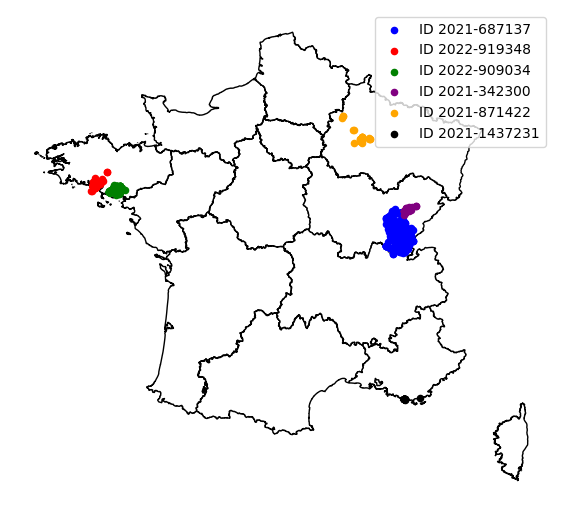

In [8]:
display(data_apartments.groupby('transaction_id').size().sort_values(ascending=False).reset_index(name = 'freq').head())

case1 = data_apartments.groupby('transaction_id').agg(
    n=('transaction_id', 'size'), n_dates=('transaction_date', 'nunique'), n_values=('property_value', 'nunique')).sort_values('n', ascending=False).reset_index()

sus = case1[(case1['n'] > 1)]

print(f'{len(sus)} powielonych transakcji co przekłada się na {len(data_apartments[data_apartments.transaction_id.isin(sus.transaction_id)])} rekordów w bazie')
display(sus[((case1['n_dates'] > 1) | (case1['n_values'] > 1))])

# MAPA

ids = sus.sort_values('n', ascending=False).head(6).transaction_id.tolist()
sub = data_apartments[data_apartments.transaction_id.isin(ids)]
sub = sub.dropna(subset=['latitude', 'longitude'])
sub = sub.drop_duplicates(['transaction_id', 'latitude', 'longitude'])

points = gpd.GeoDataFrame(sub, geometry=gpd.points_from_xy(sub.longitude, sub.latitude), crs="EPSG:4326")

url = "https://raw.githubusercontent.com/gregoiredavid/france-geojson/master/regions.geojson"
gdf = gpd.read_file(url)

colors = ['blue', 'red', 'green', 'purple', 'orange', 'black']
color_map = {tid: colors[i % len(colors)] for i, tid in enumerate(ids)}

fig, ax = plt.subplots(figsize=(7, 7))
gdf.plot(ax=ax, facecolor="white", edgecolor="black")

for tid, color in color_map.items():
    subset = points[points.transaction_id == tid]
    subset.plot(ax=ax, color=color, markersize=20, label=f"ID {tid}")

plt.legend()
ax.set_axis_off()
plt.show()

Wnioski: 
- ta sama transakcja może występować $>1$ (rozróżniana po `transaction_id`) i jest dokonywana na wszystkich obiektach tego samego dnia 
- ktoś kupił (np. firma) kilka pokoi/mieszkań w 1 transakcji 
- jest ok. 154 tys. takich `transaction_id` co przekłada się na 683 tys. rekordów 
- `property_value` jest w tych przypadkach brane całościowo za wszystkie obiekty, więc ze względu na brak chwilowej możliwości estymacji ceny pojedyńczego mieszkania wyrzucamy wszystkie takie rekordy
- z mapy widzimy, że dla najczęściej pojawiających się transakcji w bazie mieszkania są kupowane w pewnych bliskich regionach - można to dodatkowo zbadać. 

ze względu na złożoność zbioru wyrzucamy odrazu rekordy dla których `transaction_id` jest powielone

In [9]:
print(f'wielkość zbioru przed: {len(data_apartments)}')
data_apartments = data_apartments[~data_apartments.transaction_id.isin(sus.transaction_id)]
print(f'wielkość zbioru po: {len(data_apartments)}')

wielkość zbioru przed: 2229119
wielkość zbioru po: 1546144


CASE STUDY 2

sprawdzamy transakcje w obrębie tej samej lokalizacji (te same współrzędne geograficzne)

In [ ]:
case2 = data_apartments.groupby(['longitude', 'latitude']).agg(n=('longitude', 'size'), n_dates=('transaction_date', 'nunique')).reset_index()
sus = case2[(case2['n'] > 1)]

print(len(sus))
display(sus.sort_values('n', ascending=False).head())

236897


,longitude,latitude,n,n_dates
302061,5.426145,43.251494,471,354
112594,2.221061,48.791198,318,249
367715,6.940830,43.551048,243,211
324127,5.927205,44.676762,240,209
107567,2.150639,48.862845,234,200


In [ ]:
example = data_apartments[(data_apartments.longitude == 5.927205) & (data_apartments.latitude == 44.676762)]

print(
    f"liczba rekordów: {len(example)}, "
    f"liczba unikalnych lot1 number: {len(example.lot1_number.unique())}, "
    f"wielkości transakcji (w liczbie lotów): {example.number_of_lots.unique()}, "
    f"wielkości pomieszczeń (w pokojach): {example.number_of_rooms.unique()}"
)

# powielony lot
sus = example['lot1_number'].value_counts()
sus = sus[sus > 1]

display(example[example['lot1_number'].isin(sus.index)].loc[:,['transaction_id', 'transaction_date', 'property_value', 'number_of_lots', 'number_of_rooms', 
    'lot1_number', 'lot1_surface']].sort_values('transaction_date').head(11))


# być może dany lot number był współ dzielony, albo sprzedawany i kupowany ponownie

liczba rekordów: 240, liczba unikalnych lot1 number: 230, wielkości transakcji (w liczbie lotów): [1], wielkości pomieszczeń (w pokojach): [1. 2.]


,transaction_id,transaction_date,property_value,number_of_lots,number_of_rooms,lot1_number,lot1_surface
141449,2021-46736,2021-02-05,28500.0,1,1.0,1784.0,24.28
144646,2021-47943,2021-04-30,42500.0,1,1.0,1352.0,26.61
146448,2021-48596,2021-05-18,48800.0,1,1.0,1211.0,23.88
148118,2021-49246,2021-06-14,21500.0,1,1.0,1042.0,16.91
149992,2021-49973,2021-08-03,17500.0,1,1.0,2039.0,17.30
150608,2021-50220,2021-08-11,35000.0,1,1.0,1977.0,17.27
153384,2021-51322,2021-10-15,25000.0,1,1.0,1160.0,NaN
141224,2022-45819,2022-03-21,60000.0,1,1.0,1102.0,25.13
146820,2022-47944,2022-07-01,28500.0,1,1.0,1160.0,25.94
148354,2022-48529,2022-08-02,47970.0,1,1.0,1499,24.12


![opis obrazka](case_study1.png)

Wnioski:
- dany obiekt może być mocno podzielony - dużo różnych transakcji w obrębie tego samego bloku, np. sprzedawane są pojedyńcze pokoje w dużym ośrodku wypoczynkowym
- w danym obiekcie w obrębie pojedyńczej transakcji może być kupione dużo lokali, np. ktoś wykupił 2000 lokali w danym -> mocno podejrzane transakcje, które zostały wyrzucone po case study 1
- w danym budynku lot number może być sprzedawany kilka razy w czasie - może jest współdzielony, lub sprzedawany ponownie komuś innemu (case study 3)

CASE STUDY 3

sprawdzamy unikalność danych lot number w obrębie danego budynku i danej daty

In [12]:
case31 = data_apartments.groupby(['longitude', 'latitude', 'transaction_date', 'lot1_number']).agg(n=('longitude', 'size')).reset_index()
sus = case31[(case31['n'] > 1)]

print(len(sus))
display(sus.sort_values('n', ascending=False))

818


,longitude,latitude,transaction_date,lot1_number,n
504945,2.281485,48.904879,2022-05-13,8.0,3
83910,-1.649396,49.648415,2023-03-20,3,3
784586,2.672932,42.473922,2024-12-20,65,3
598284,2.342731,48.918626,2023-10-12,539.0,3
988592,4.450276,46.803166,2024-05-17,8.0,3
...,...,...,...,...,...
1504053,55.270877,-21.011410,2022-03-10,2,2
1506371,55.450193,-20.872869,2024-07-22,39.0,2
1508868,55.477493,-20.896558,2023-07-18,34,2
1510602,55.489856,-20.901885,2022-06-30,108,2


In [13]:
lon, lat, lot = 2.281485, 48.904879	, 8 

example = data_apartments[(data_apartments.longitude == lon) & (data_apartments.latitude == lat) & (data_apartments.lot1_number == lot)]

display(example.loc[:,['transaction_id', 'transaction_date', 'property_value', 'lot1_number', 'lot1_surface', 'number_of_lots', 'number_of_rooms', 
    'built_surface']].sort_values('transaction_date'))

,transaction_id,transaction_date,property_value,lot1_number,lot1_surface,number_of_lots,number_of_rooms,built_surface
4291877,2022-1522102,2022-05-13,85000.0,8.0,52.13,1,3.0,57.0
4291936,2022-1522129,2022-05-13,85000.0,8.0,52.13,1,3.0,57.0
4293995,2022-1522967,2022-05-13,85000.0,8.0,52.13,1,3.0,57.0


sprawdzamy unikalność danych lot number w obrębie danego budynku

In [14]:
case32 = data_apartments.groupby(['longitude', 'latitude', 'lot1_number']).agg(n=('longitude', 'size'), n_dates=('transaction_date', 'nunique')).reset_index()

sus = case32[(case32['n'] > 1)]

print(len(sus))
display(sus.sort_values('n', ascending=False).head(10))

46488


,longitude,latitude,lot1_number,n,n_dates
1176655,5.721841,45.179932,28.0,8,7
597414,2.351724,48.862491,152.0,5,5
1065574,5.031587,47.323233,27.0,5,4
1066146,5.034004,47.319035,32.0,5,5
1386510,7.040578,43.544078,101.0,5,4
684330,2.424229,48.783709,145.0,4,4
87428,-1.597475,48.838592,11,4,3
293630,1.254982,45.839767,23.0,4,4
104821,-1.541639,47.215813,3.0,4,4
384939,2.039532,48.926288,39.0,4,4


In [15]:
lon, lat, lot = 2.424229, 48.783709, 145 # [5.721841, 45.179932, 28]	

example = data_apartments[(data_apartments.longitude == lon) & (data_apartments.latitude == lat) & (data_apartments.lot1_number == lot)]

display(example.loc[:,['transaction_id', 'transaction_date', 'property_value', 'lot1_number', 'lot1_surface', 'number_of_lots', 'number_of_rooms', 
    'built_surface']].sort_values('transaction_date'))

,transaction_id,transaction_date,property_value,lot1_number,lot1_surface,number_of_lots,number_of_rooms,built_surface
4440738,2021-1616255,2021-02-25,230000.0,145.0,40.13,1,2.0,39.0
4462162,2021-1626512,2021-07-27,230000.0,145.0,40.13,1,2.0,39.0
4472095,2022-1596436,2022-12-19,268500.0,145.0,40.13,1,2.0,39.0
3637556,2023-1285147,2023-12-20,195450.0,145.0,40.13,1,2.0,39.0


Wnioski:

- dany lot number w ustaonym budynku w ciągu dnia może być sprzedany $>1$ w obrębie różnych transakcji - zakładamy że to duplikaty
- lot number w danym budynku może być sprzedawany kilka razy w czasie - może być jakoś współdzielony, lub kupowany ponownie przez kogoś innego

w sposób losowy zostawiamy unikalną kombinację `longitude` x `latitude` x `lot1_number` żeby zachować unikalność konkretnych jednostek mieszkalnych

In [17]:
print(f'wielkość zbioru przed: {len(data_apartments)}')

prev = data_apartments[~data_apartments.set_index(['longitude', 'latitude', 'lot1_number']).index.isin(sus.set_index(['longitude', 'latitude', 'lot1_number']).index)]

sampled = (data_apartments[data_apartments.set_index(['longitude', 'latitude', 'lot1_number']).index.isin(sus.set_index(['longitude', 'latitude', 'lot1_number']).index)
    ].groupby(['longitude', 'latitude', 'lot1_number'], group_keys=False).apply(lambda x: x.sample(1, random_state=42)))


data_apartments = pd.concat([prev, sampled]).reset_index(drop=True)
print(f'wielkość zbioru po: {len(data_apartments)}')

wielkość zbioru przed: 1546144


C:\Users\jpiec\AppData\Local\Temp\ipykernel_25256\260860458.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ].groupby(['longitude', 'latitude', 'lot1_number'], group_keys=False).apply(lambda x: x.sample(1, random_state=42)))


wielkość zbioru po: 1498834


3. BRAKI DANYCH

sprawdzamy % braków danych w podziale na kolumny

In [19]:
data_null = data_apartments.isna().sum() / len(data_apartments) * 100
data_null = data_null.rename('missing_rate')
data_null = data_null.sort_values(ascending=False)

display(data_null)
display(data_null.loc[['price_per_m_2']])

remove_col = data_null[data_null > 80].index
data_apartments = data_apartments.loc[:, ~data_apartments.columns.isin(remove_col)]


old_parcel_id            100.000000
volume_number            100.000000
old_commune_name          99.999733
old_commune_code          99.999733
special_land_use_code     99.990059
special_land_use          99.990059
lot5_surface              99.936217
lot4_surface              99.767086
lot5_number               99.476727
lot3_surface              98.819949
land_area                 98.528123
land_use_code             98.527989
land_use                  98.527989
lot4_number               98.499033
lot3_number               94.242391
address_suffix            93.673549
lot2_surface              85.576521
lot2_number               55.778092
lot1_surface              48.385345
lot1_number                1.406226
address_number             0.853997
longitude                  0.789681
latitude                   0.789681
price_per_m_2              0.045902
property_value             0.036695
built_surface              0.009207
number_of_rooms            0.009207
postal_code                0

price_per_m_2    0.045902
Name: missing_rate, dtype: float64

ZWYKLE DROP DUPLICATES SPRAWDZIC!!!

4. ANALIZA TARGETU

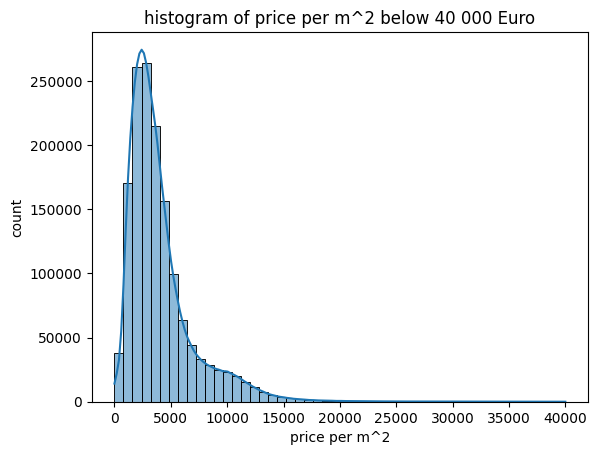

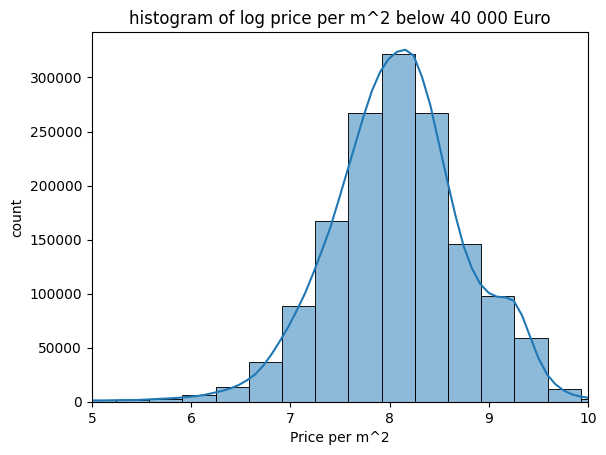

AttributeError: 'DataFrame' object has no attribute 'transaction_date'

In [26]:
plot3 = data_apartments['price_per_m_2'].dropna()
plot3 = plot3[plot3 < 40_000]  

sns.histplot(plot3, bins=50, kde=True)
plt.title("histogram of price per m^2 below 40 000 Euro")
plt.xlabel("price per m^2")
plt.ylabel("count")
plt.show()

plot3 = np.log(plot3)

sns.histplot(plot3, bins=50, kde=True)
plt.title("histogram of log price per m^2 below 40 000 Euro")
plt.xlabel("Price per m^2")
plt.xlim((5,10))
plt.ylabel("count")
plt.show()



plot4 = data_apartments.groupby(data_apartments.year).price_per_m_2.mean().reset_index(name = 'price_per_m_2')

plot4 = pd.DataFrame({'Year': plot4.transaction_date.astype(str), 'price_per_m_2': plot4.price_per_m_2})
sns.lineplot(data = plot4, x="Year", y="price_per_m^2", marker = "o")
plt.title("Price per m^2 per year")
plt.show()


plot4 = data_apartments.groupby(data_apartments.month).price_per_m_2.mean().reset_index(name='price_per_m_2')
plot4['month'] = plot4.month.astype(str)

sns.lineplot(data = plot4, x="month", y="price_per_m_2", marker = "o")
plt.title("Price per m^2 per month")
plt.xticks(rotation=90)
plt.xticks(fontsize=8)  
plt.yticks(fontsize=8)
plt.title('Price per month')
plt.tight_layout()
plt.show()

KOŃCOWA STABILNOŚĆ DANYCH

stabilność w czasie

In [ ]:
plot1 = pd.DataFrame({'Year': years, 'size': data_size})
sns.barplot(data = plot1, x="Year", y="size")
plt.title("Sample size per year")
plt.show()



plot2 = data_apartments[data_apartments.transaction_date >= pd.to_datetime('2023-01-01')]
plot2 = plot2.month_year.value_counts().reset_index(name='sample_size').sort_values('month_year')
plot2['month_year'] = plot2.month_year.astype(str)

sns.barplot(data = plot2, x= "month_year", y="sample_size")
plt.title('Sample size per month-year')
plt.xticks(rotation=45)
plt.title('Sample size per month-year')
plt.tight_layout()
plt.show()

stabilność w przestrzeni (musimy potem wyrzucić terytorium zamorskie, ale to jak ogarniemy adres)

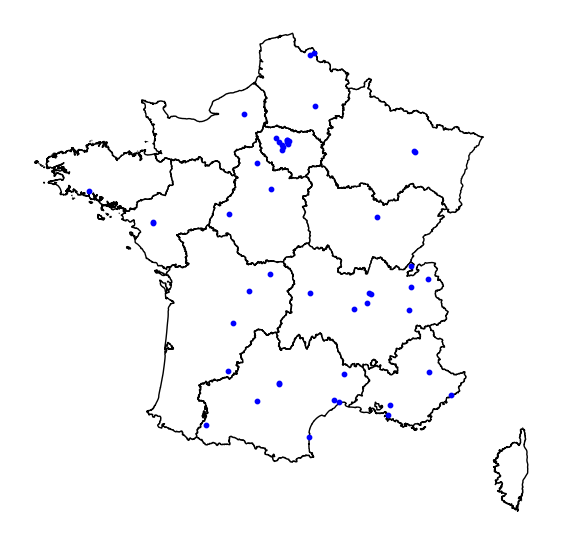

In [30]:
sub = data_apartments.sample(50, random_state=42)

points = gpd.GeoDataFrame(sub, geometry=gpd.points_from_xy(sub.longitude, sub.latitude), crs="EPSG:4326")


url = "https://raw.githubusercontent.com/gregoiredavid/france-geojson/master/regions.geojson"
gdf = gpd.read_file(url)


fig, ax = plt.subplots(figsize=(7, 7))
gdf.plot(ax=ax, facecolor="white", edgecolor="black")

points.plot(ax=ax, color="blue", markersize=10)

ax.set_axis_off()
plt.show()

